# Premier modele de classification  simple (1 forme par image) 

Dans un premier temps, nous avons tenté de dé
finir et entraîner un modèle de classification simple par réseau de neurones profond (deep learning). Nous avons eu recours:
- à une méthode de transfert learning, en réutilisant une architecture de type VGG19 pré-entrainée
- à l'augmentation de donnée

La prédiction de ce modèle permet de classer les images mono-formes: elle renvoit une classe par image, pouvant prendre 4 valeurs (Fish, Flower, Gravel, Sugar).
C'est donc une approche par classification simple, qui ne nous permettra pas de trouver plusieurs formes dans une même image.

In [1]:
#Importation des packages nécessaires
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils
import tensorflow as tf
import os
import pandas as pd

import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import applications
from keras import optimizers
from keras.applications import VGG19
from keras.models import Model
from sklearn import metrics
import itertools
from keras import layers

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras import backend
from tensorflow.keras import callbacks
from tensorflow.keras import initializers

from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## I. Préparation des données d'entraînement et de test

De manière classique, nous allons préparer nos données. Nous rechargeons directement notre csv avec les différentes classes présentes.

In [2]:
#On lit de fichier CSV contenant une seule forme par image
import pandas as pd
df=pd.read_csv('df_corr.csv',encoding = "utf-8",index_col='ImageId')
df_all = df
df['nb_formes'] = df.Label_Fish + df.Label_Flower + df.Label_Gravel + df.Label_Sugar 
df.head()

,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar,Multilabel,nb_formes
ImageId,,,,,,
0011165.jpg,1,1,0,0,Fish-Flower,2
002be4f.jpg,1,1,0,1,Fish-Flower-Sugar,3
0031ae9.jpg,1,1,0,1,Fish-Flower-Sugar,3
0035239.jpg,0,1,1,0,Flower-Gravel,2
003994e.jpg,1,0,1,1,Fish-Gravel-Sugar,3


Comme il s'agit d'un problème de classification simple, nous ne conservons que les images avec 1 seule forme. Et nous éliminons également les 2 images problématiques.

In [3]:
df = df[df['nb_formes'] == 1]
df=df[df.index != "e5f2f24.jpg"]
df=df[df.index != "c26c635.jpg"]
df.shape

(1347, 6)

Nous avons également créé un dataframe df_all qui contiendra toutes les images (mono et multi formes) pour la copie des images de taille réduite que nous effectuons plus bas, afin de ne pas répéter l'opération pour le modèle de classification multiple.

In [4]:
df_all = df_all[df_all.index != "e5f2f24.jpg"]
df_all=df_all[df_all.index != "c26c635.jpg"]
df_all.shape

(5544, 6)

Nous modifions ce dataframe pour ne conserver que 2 colonnes: l'un contenant nos images, et l'autre contenant la classe de l'image que l'on va chercher à prédire.

In [5]:

def modify_path(img):
    path = 'train_images_500/' + str(img)
    return path
def getclass(row):
    if row.Label_Fish == 1:
        return 0
    if row.Label_Flower == 1:
        return 1
    if row.Label_Gravel == 1:
        return 2
    if row.Label_Sugar == 1:
        return 3   
df_data = df
df_data['path'] = df.index.map(modify_path)
df_data['class']= df.apply(lambda row: getclass(row), axis = 1)
df_data = df_data.reset_index()
df_data = df_data.drop(['ImageId','nb_formes','Label_Fish','Label_Flower','Label_Gravel','Label_Sugar','Multilabel'], axis = 1)
df_data.head()

,path,class
0,train_images_500/00498ec.jpg,2
1,train_images_500/008233e.jpg,3
2,train_images_500/0095357.jpg,3
3,train_images_500/00d4443.jpg,3
4,train_images_500/0104b5b.jpg,3


In [6]:
df_data.shape

(1347, 2)

### Réduction des images

Pour la classification nous avons chargé toutes les images en mémoire. C'est quelque chose que nous avons ensuite modifié pour notre modèle final. Mais ça ce stade, nous avons du créé un folder dédié, nommé train_images_500,  dans lequel nous avons copié nos images de dimension réduite (500 x 500 pour nos modèles de classification).


In [7]:
# Constants
image_width = 500
image_height = 500
img_size = 500
channels = 3
batch_size = 64
IMG_SHAPE = 500

In [22]:
# traitement des images on doit créer nos images en 400 par 400 et cette fois pour tout le trade set
import os
TRAIN_PATH = 'train_images/'
TARGET_PATH = 'train_images_500/'


# nous allons récupérer l'ensemble des dimensions des images de l'ensemble d'entrainement
# on itère sur les images on les redimensionne et on les sauve dans le nouveau dossier
for img in df_all.index:
    path_img = TRAIN_PATH + img
    #print(train_path)
    image = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
    new_img = cv2.resize(image, (img_size, img_size))
    new_path = TARGET_PATH + "/" + str(img)
    cv2.imwrite(new_path, new_img)


### Split du jeu de données et augmentation de données

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_data, test_size = 0.2)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          #shear_range = 0.2,
                                          rotation_range = 10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 0.1,
                                          #horizontal_flip = True,
                                          fill_mode='nearest'
                                         )

test_data_generator = ImageDataGenerator(rescale = 1./255) #

In [10]:
X_train.head(5)
batch_size = 32
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col = 'class',
                                                           class_mode ="sparse",
                                                          shuffle = False,
                                                          target_size = (img_size , img_size), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col = 'class',
                                                           class_mode ="sparse",
                                                          shuffle = False,
                                                          target_size = (img_size , img_size), 
                                                          batch_size = batch_size)

Found 1077 validated image filenames belonging to 4 classes.
Found 270 validated image filenames belonging to 4 classes.


### Definition du modèle de deep learning

Nous utilisons un VGG12 pré-entraîné sur lequel nous freezons les 15 premières couches, puis nous rajoutons quelques couches denses.

In [12]:
# Loading Model VGG19
pretrained_model = VGG19(input_shape=(image_height, image_width, channels), include_top=False, weights="imagenet")
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [13]:
# Freezing the layers 
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for layer in pretrained_model.layers[15:]:
    layer.trainable = True

In [14]:
# Modification of pretrained model
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
 
x = GlobalMaxPooling2D()(last_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(4, activation='sigmoid')(x)

In [15]:
# Creating a new model
model = Model(pretrained_model.input, x)

In [16]:
#Callbacks
n_epochs = 20
import os
cwd = os.getcwd()
filepath = cwd
from keras.optimizers import Adam
from tensorflow.keras import callbacks

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience=2,
                                         verbose=2,
                                         mode='min')
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 5,
                                         mode = 'min',
                                         restore_best_weights = True) 
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 10 == 0:
        return learning_rate * 0.1
    else: 
        return learning_rate
    
lrScheduler = callbacks.LearningRateScheduler(schedule = decreasinglrUpdate,
                                              verbose = 1)

checkpoint = callbacks.ModelCheckpoint(filepath = "Modele1_classi_simple.best.hdf5", 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
#loss=binary_crossentropy

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)    

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=n_epochs,
    validation_data=test_generator,
    #validation_steps=n_validation_samples//batch_size,
    #steps_per_epoch=n_training_samples//batch_size,
    callbacks = [lrScheduler, early_stopping, checkpoint],
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/20


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15) # fonction pour récupérer le nbre d'epochs ?

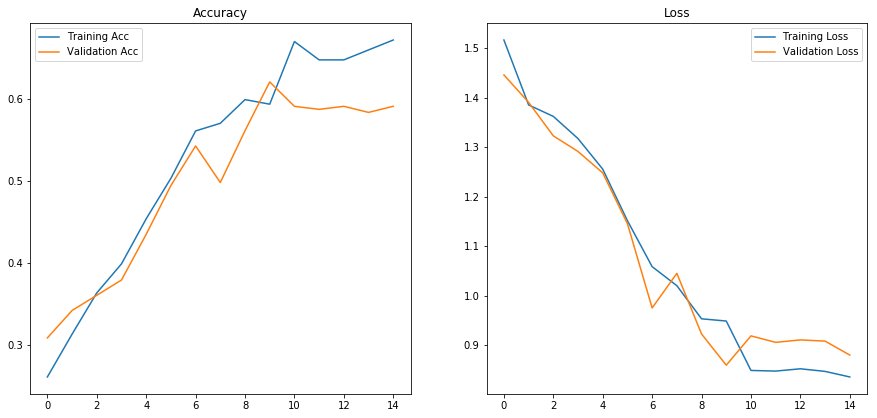

In [18]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend()
plt.title('Accuracy')


plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [19]:
from sklearn.metrics import classification_report
y_pred = model.predict_generator(test_generator)
y_pred_class = y_pred.argmax(axis = 1)
#print(type(y_pred_class))
y_test_class = X_test['class'].to_numpy(dtype = 'int')
#print(y_test_class)
print(classification_report(y_test_class, y_pred_class, target_names = ['FISH','FLOWER','GRAVEL','SUGAR']))

              precision    recall  f1-score   support

        FISH       0.68      0.57      0.62        69
      FLOWER       0.64      0.80      0.71        59
      GRAVEL       0.60      0.40      0.48        62
       SUGAR       0.58      0.71      0.64        79

    accuracy                           0.62       269
   macro avg       0.63      0.62      0.61       269
weighted avg       0.62      0.62      0.61       269



In [20]:
cm = pd.crosstab(y_test_class, y_pred_class, rownames=['Realité'], colnames=['Prédiction'])
cm

Prédiction,0,1,2,3
Realité,,,,
0,39,14,8,8
1,3,47,2,7
2,6,5,25,26
3,9,7,7,56


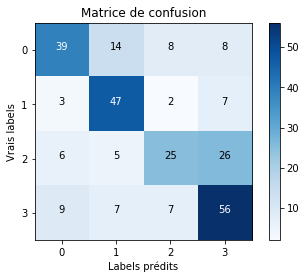

In [21]:
from sklearn import metrics
import itertools

cnf_matrix = metrics.confusion_matrix(y_test_class, y_pred_class)

classes = range(0,4)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("model1_classi_simple.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_1_classi_simple.h5")
print("Saved model to disk")

Saved model to disk
